## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## 2. Define Feature Engineering Transformers

We'll create custom transformers for each feature engineering step that can be used in a sklearn Pipeline.

In [2]:
class DatetimeFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract datetime features: year, month, day, weekday, hour"""
    
    def __init__(self, datetime_col='pickup_datetime'):
        self.datetime_col = datetime_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[f'{self.datetime_col}_year'] = X[self.datetime_col].dt.year
        X[f'{self.datetime_col}_month'] = X[self.datetime_col].dt.month
        X[f'{self.datetime_col}_day'] = X[self.datetime_col].dt.day
        X[f'{self.datetime_col}_weekday'] = X[self.datetime_col].dt.weekday
        X[f'{self.datetime_col}_hour'] = X[self.datetime_col].dt.hour
        return X

In [3]:
class DistanceCalculator(BaseEstimator, TransformerMixin):
    """Calculate haversine distance between pickup and dropoff locations"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['trip_distance'] = self._haversine_distance(
            X['pickup_longitude'], X['pickup_latitude'],
            X['dropoff_longitude'], X['dropoff_latitude']
        )
        return X
    
    @staticmethod
    def _haversine_distance(lon1, lat1, lon2, lat2):
        """Calculate great circle distance in kilometers"""
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        
        return km

In [4]:
class LandmarkDistanceCalculator(BaseEstimator, TransformerMixin):
    """Calculate distances from major NYC landmarks"""
    
    def __init__(self):
        # NYC landmark coordinates (longitude, latitude)
        self.landmarks = {
            'jfk': (-73.7781, 40.6413),
            'lga': (-73.8740, 40.7769),
            'ewr': (-74.1745, 40.6895),
            'met': (-73.9632, 40.7794),
            'wtc': (-74.0099, 40.7126)
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for name, (lon, lat) in self.landmarks.items():
            # Distance from pickup location
            X[f'{name}_pickup_distance'] = self._haversine_distance(
                lon, lat, X['pickup_longitude'], X['pickup_latitude']
            )
            # Distance from dropoff location
            X[f'{name}_drop_distance'] = self._haversine_distance(
                lon, lat, X['dropoff_longitude'], X['dropoff_latitude']
            )
        
        return X
    
    @staticmethod
    def _haversine_distance(lon1, lat1, lon2, lat2):
        """Calculate great circle distance in kilometers"""
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        
        return km

In [5]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    """Remove outliers and invalid data based on reasonable ranges"""
    
    def __init__(self, 
                 fare_range=(1, 500),
                 lon_range=(-75, -72),
                 lat_range=(40, 42),
                 passenger_range=(1, 6)):
        self.fare_range = fare_range
        self.lon_range = lon_range
        self.lat_range = lat_range
        self.passenger_range = passenger_range
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        
        # Only apply fare filter if fare_amount column exists (training data)
        if 'fare_amount' in X.columns:
            mask = (
                (X['fare_amount'] >= self.fare_range[0]) &
                (X['fare_amount'] <= self.fare_range[1]) &
                (X['pickup_longitude'] >= self.lon_range[0]) & 
                (X['pickup_longitude'] <= self.lon_range[1]) & 
                (X['dropoff_longitude'] >= self.lon_range[0]) & 
                (X['dropoff_longitude'] <= self.lon_range[1]) & 
                (X['pickup_latitude'] >= self.lat_range[0]) & 
                (X['pickup_latitude'] <= self.lat_range[1]) & 
                (X['dropoff_latitude'] >= self.lat_range[0]) & 
                (X['dropoff_latitude'] <= self.lat_range[1]) & 
                (X['passenger_count'] >= self.passenger_range[0]) & 
                (X['passenger_count'] <= self.passenger_range[1])
            )
        else:
            # For test data without fare_amount
            mask = (
                (X['pickup_longitude'] >= self.lon_range[0]) & 
                (X['pickup_longitude'] <= self.lon_range[1]) & 
                (X['dropoff_longitude'] >= self.lon_range[0]) & 
                (X['dropoff_longitude'] <= self.lon_range[1]) & 
                (X['pickup_latitude'] >= self.lat_range[0]) & 
                (X['pickup_latitude'] <= self.lat_range[1]) & 
                (X['dropoff_latitude'] >= self.lat_range[0]) & 
                (X['dropoff_latitude'] <= self.lat_range[1]) & 
                (X['passenger_count'] >= self.passenger_range[0]) & 
                (X['passenger_count'] <= self.passenger_range[1])
            )
        
        return X[mask]

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select only the features needed for modeling"""
    
    def __init__(self, feature_columns=None):
        self.feature_columns = feature_columns
    
    def fit(self, X, y=None):
        if self.feature_columns is None:
            # Define default feature columns
            self.feature_columns = [
                'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
                'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
                'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
                'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
                'met_drop_distance', 'wtc_drop_distance', 'jfk_pickup_distance',
                'lga_pickup_distance', 'ewr_pickup_distance', 'met_pickup_distance',
                'wtc_pickup_distance'
            ]
        return self
    
    def transform(self, X):
        return X[self.feature_columns]

## 3. Create Feature Engineering Pipeline

In [7]:
# Create the feature engineering pipeline
feature_pipeline = Pipeline([
    ('datetime_features', DatetimeFeatureExtractor()),
    ('trip_distance', DistanceCalculator()),
    ('landmark_distances', LandmarkDistanceCalculator()),
    ('outlier_removal', OutlierRemover()),
    ('feature_selection', FeatureSelector())
])

print("Feature Engineering Pipeline created successfully!")
print("\nPipeline steps:")
for step_name, step in feature_pipeline.steps:
    print(f"  - {step_name}: {step.__class__.__name__}")

Feature Engineering Pipeline created successfully!

Pipeline steps:
  - datetime_features: DatetimeFeatureExtractor
  - trip_distance: DistanceCalculator
  - landmark_distances: LandmarkDistanceCalculator
  - outlier_removal: OutlierRemover
  - feature_selection: FeatureSelector


## 4. Load and Prepare Data

In [10]:
# Configuration
SAMPLE_FRACTION = 100  # Use 10% of data for faster training
RANDOM_STATE = 42

# Data types for efficient loading
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

selected_cols = [
    'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
]

In [12]:
# def skip_row(row_idx):
#     """Skip rows randomly to sample data"""
#     if row_idx == 0:
#         return False
#     return random.random() > SAMPLE_FRACTION

# # Set random seed for reproducibility
# random.seed(RANDOM_STATE)

# Load training data
print(f"Loading {SAMPLE_FRACTION}% of training data...")
df = pd.read_csv(
    'train.csv',
    usecols=selected_cols,
    dtype=dtypes,
    parse_dates=['pickup_datetime'],
    skiprows=skip_row
)

print(f"Loaded {len(df):,} rows")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Loading 100% of training data...
Loaded 55,423,856 rows
Memory usage: 1532.83 MB


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [13]:
# Basic data info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nMissing values:\n{df.isna().sum()}")
print(f"\nBasic statistics:")
df.describe()

Dataset Info:
Shape: (55423856, 7)

Missing values:
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

Basic statistics:


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991980e+01,-7.251122e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


## 5. Split Data Before Feature Engineering

In [14]:
# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

print(f"Training set: {len(train_df):,} rows")
print(f"Validation set: {len(val_df):,} rows")

# Remove any missing values
train_df = train_df.dropna()
val_df = val_df.dropna()

print(f"\nAfter dropping NAs:")
print(f"Training set: {len(train_df):,} rows")
print(f"Validation set: {len(val_df):,} rows")

Training set: 44,339,084 rows
Validation set: 11,084,772 rows

After dropping NAs:
Training set: 44,338,787 rows
Validation set: 11,084,693 rows


## 6. Apply Feature Engineering Pipeline

In [15]:
# Separate features and target for training data
y_train = train_df['fare_amount'].values
y_val = val_df['fare_amount'].values

print("Applying feature engineering pipeline to training data...")
X_train = feature_pipeline.fit_transform(train_df)

print("Applying feature engineering pipeline to validation data...")
X_val = feature_pipeline.transform(val_df)

# Update targets after outlier removal
y_train = train_df.loc[X_train.index, 'fare_amount'].values
y_val = val_df.loc[X_val.index, 'fare_amount'].values

print(f"\nFeature engineering complete!")
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"\nFeature columns: {list(X_train.columns)}")

Applying feature engineering pipeline to training data...
Applying feature engineering pipeline to validation data...

Feature engineering complete!
Training features shape: (43250514, 21)
Validation features shape: (10811918, 21)

Feature columns: ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day', 'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance', 'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance', 'wtc_drop_distance', 'jfk_pickup_distance', 'lga_pickup_distance', 'ewr_pickup_distance', 'met_pickup_distance', 'wtc_pickup_distance']


In [16]:
# Display sample of engineered features
print("Sample of engineered features:")
X_train.head()

Sample of engineered features:


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,...,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance,jfk_pickup_distance,lga_pickup_distance,ewr_pickup_distance,met_pickup_distance,wtc_pickup_distance
3803079,-73.965027,40.763531,-73.959755,40.766003,1,2012,7,23,0,8,...,20.645109,7.317645,19.982992,1.516823,7.283101,20.796476,7.803318,19.464788,1.769837,6.805206
29954301,-74.001984,40.729961,-73.974098,40.788872,2,2015,4,28,1,17,...,23.269461,8.526846,20.165918,1.395889,8.995789,21.283829,11.969898,15.211747,6.390472,2.041336
50872271,-73.981125,40.729317,-73.983154,40.723549,1,2014,4,12,5,19,...,19.548372,10.935517,16.557154,6.429624,2.560327,19.706919,10.453700,16.879450,5.766274,3.053580
1510253,-73.984947,40.761517,-73.955956,40.803623,5,2011,3,11,4,16,...,23.446693,7.507485,22.346264,2.759996,11.087358,21.957485,9.492127,17.857437,2.701127,5.828048
40007477,-74.036942,40.730091,-74.039932,40.721855,1,2011,12,19,0,21,...,23.811821,15.249617,11.892625,9.089314,2.730586,23.939676,14.669503,12.434440,8.279602,2.994147


## 7. Train Model

In [26]:
# Define model with best hyperparameters from tuning
model = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

print("Training XGBoost model...")
print(f"Model parameters: {model.get_params()}")

Training XGBoost model...
Model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [27]:
%%time
# Train the model
model.fit(X_train, y_train)
print("\nModel training complete!")


Model training complete!
CPU times: total: 2h 13min 46s
Wall time: 10min 5s


## 8. Evaluate Model

In [28]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Evaluate model performance on train and validation sets"""
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Calculate RMSE manually (sqrt of MSE)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    print("Model Performance:")
    print(f"  Training RMSE:   ${train_rmse:.4f}")
    print(f"  Validation RMSE: ${val_rmse:.4f}")
    print(f"  Difference:      ${abs(train_rmse - val_rmse):.4f}")
    
    return train_rmse, val_rmse

train_rmse, val_rmse = evaluate_model(model, X_train, y_train, X_val, y_val)

Model Performance:
  Training RMSE:   $3.4940
  Validation RMSE: $3.5287
  Difference:      $0.0348



Top 10 Most Important Features:
                 feature  importance
10         trip_distance    0.584850
0       pickup_longitude    0.107025
15     wtc_drop_distance    0.067481
18   ewr_pickup_distance    0.042847
14     met_drop_distance    0.029123
2      dropoff_longitude    0.028980
13     ewr_drop_distance    0.020618
12     lga_drop_distance    0.017836
5   pickup_datetime_year    0.017694
16   jfk_pickup_distance    0.014150


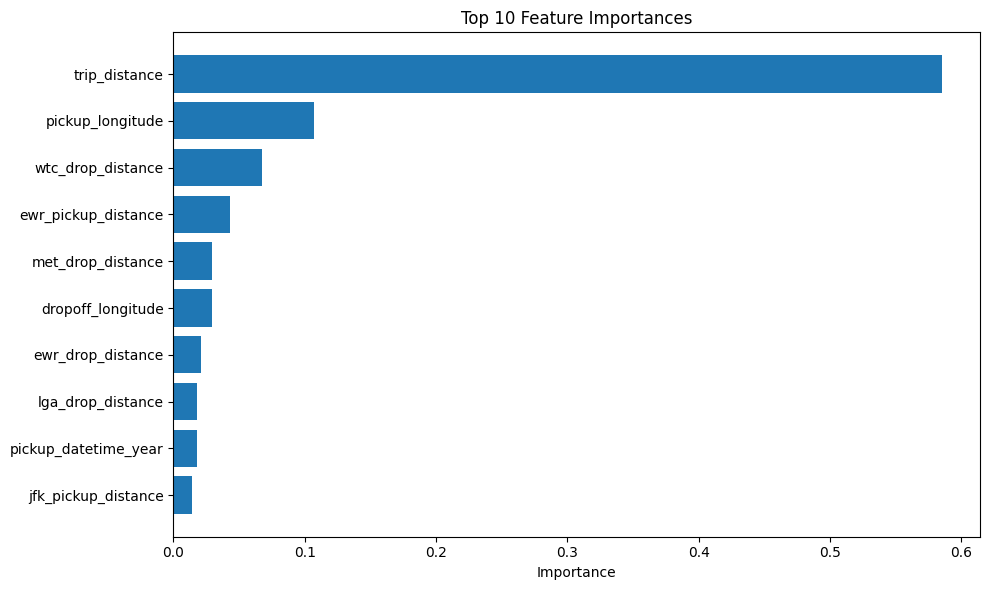

In [21]:
# Feature importance
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Complete Prediction Pipeline

In [29]:
class TaxiFarePredictionPipeline:
    """Complete pipeline for NYC taxi fare prediction"""
    
    def __init__(self, feature_pipeline, model):
        self.feature_pipeline = feature_pipeline
        self.model = model
    
    def predict(self, data):
        """Make predictions on new data"""
        # Apply feature engineering
        features = self.feature_pipeline.transform(data)
        
        # Make predictions
        predictions = self.model.predict(features)
        
        return predictions
    
    def predict_from_csv(self, csv_path):
        """Load data from CSV and make predictions"""
        # Load data
        dtypes = {
            'pickup_longitude': 'float32',
            'pickup_latitude': 'float32',
            'dropoff_longitude': 'float32',
            'dropoff_latitude': 'float32',
            'passenger_count': 'uint8'
        }
        
        data = pd.read_csv(csv_path, dtype=dtypes, parse_dates=['pickup_datetime'])
        
        # Make predictions
        predictions = self.predict(data)
        
        return predictions

# Create the complete pipeline
prediction_pipeline = TaxiFarePredictionPipeline(feature_pipeline, model)
print("Complete prediction pipeline created!")

Complete prediction pipeline created!


In [30]:
train_rmse

np.float64(3.4939636219753365)

## 10. Test Pipeline on Sample Data

In [31]:
# Test on a few validation samples
sample_data = val_df.head(10).copy()

# Make predictions
predictions = prediction_pipeline.predict(sample_data)

# Display results
results = pd.DataFrame({
    'Actual Fare': sample_data['fare_amount'].values[:len(predictions)],
    'Predicted Fare': predictions,
    'Difference': sample_data['fare_amount'].values[:len(predictions)] - predictions,
    'Pickup Location': sample_data.apply(
        lambda x: f"({x['pickup_latitude']:.4f}, {x['pickup_longitude']:.4f})", axis=1
    ).values[:len(predictions)],
    'Dropoff Location': sample_data.apply(
        lambda x: f"({x['dropoff_latitude']:.4f}, {x['dropoff_longitude']:.4f})", axis=1
    ).values[:len(predictions)]
})

print("\nSample Predictions:")
print(results.to_string(index=False))


Sample Predictions:
 Actual Fare  Predicted Fare  Difference     Pickup Location    Dropoff Location
         3.3        4.104817   -0.804817 (40.7785, -73.9533) (40.7725, -73.9534)
         6.5        7.037782   -0.537782 (40.7383, -73.9855) (40.7389, -74.0033)
         5.0        5.320259   -0.320259 (40.7181, -73.9999) (40.7231, -73.9992)
        40.5       31.165550    9.334450 (40.7562, -73.9745) (40.8672, -73.9231)
         7.7        8.821645   -1.121645 (40.7864, -73.9528) (40.7628, -73.9740)
         4.0        4.588226   -0.588226 (40.7631, -73.9564) (40.7692, -73.9520)
         6.5        5.583395    0.916605 (40.7597, -73.9856) (40.7503, -73.9947)
        13.0       11.273638    1.726362 (40.7451, -73.9949) (40.7154, -74.0129)
        16.1       16.218168   -0.118168 (40.7605, -73.9911) (40.7018, -74.0111)
         5.7        5.522309    0.177691 (40.7557, -73.9756) (40.7424, -73.9817)


## 11. Make Predictions on Test Data (if available)

In [34]:
# Check if test.csv exists
import os

if os.path.exists('test.csv'):
    print("Loading test data...")
    test_df = pd.read_csv(
        'test.csv',
        dtype=dtypes,
        parse_dates=['pickup_datetime']
    )
    
    print(f"Test data shape: {test_df.shape}")
    
    # Apply feature engineering
    print("Applying feature engineering to test data...")
    X_test = feature_pipeline.transform(test_df)
    
    # Make predictions
    print("Making predictions on test data...")
    test_predictions = model.predict(X_test)
    
    print(f"\nGenerated {len(test_predictions)} predictions")
    print(f"Prediction range: ${test_predictions.min():.2f} - ${test_predictions.max():.2f}")
    print(f"Mean prediction: ${test_predictions.mean():.2f}")
    
    # Save predictions if key column exists
    if 'key' in test_df.columns:
        submission_df = pd.DataFrame({
            'key': test_df.loc[X_test.index, 'key'],
            'fare_amount': test_predictions
        })
        submission_df.to_csv('pipeline_submission.csv', index=False)
        print("\nSubmission file saved as 'pipeline_submission.csv'")
else:
    print("Test data not found. Skipping test predictions.")

Loading test data...
Test data shape: (9914, 7)
Applying feature engineering to test data...
Making predictions on test data...

Generated 9914 predictions
Prediction range: $3.48 - $110.74
Mean prediction: $11.40

Submission file saved as 'pipeline_submission.csv'


## 12. Save Pipeline for Future Use

In [35]:
import pickle

# Save the complete pipeline
with open('taxi_fare_2.pkl', 'wb') as f:
    pickle.dump({
        'feature_pipeline': feature_pipeline,
        'model': model,
        'feature_columns': list(X_train.columns),
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    }, f)

print("Pipeline saved as 'taxi_fare_pipeline.pkl'")
print("\nTo load the pipeline later:")
print("""with open('taxi_fare_pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)
    feature_pipeline = pipeline_data['feature_pipeline']
    model = pipeline_data['model']""")

Pipeline saved as 'taxi_fare_pipeline.pkl'

To load the pipeline later:
with open('taxi_fare_pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)
    feature_pipeline = pipeline_data['feature_pipeline']
    model = pipeline_data['model']


## Summary

This notebook implements a complete ML pipeline for NYC taxi fare prediction:

### Feature Engineering Pipeline:
1. **DatetimeFeatureExtractor**: Extracts year, month, day, weekday, hour from pickup datetime
2. **DistanceCalculator**: Calculates haversine distance between pickup and dropoff
3. **LandmarkDistanceCalculator**: Calculates distances from major NYC landmarks (JFK, LGA, EWR, Met, WTC)
4. **OutlierRemover**: Removes outliers and invalid data
5. **FeatureSelector**: Selects only relevant features for modeling

### Model:
- **XGBoost Regressor** with tuned hyperparameters

### Usage:
The pipeline can be used to:
- Transform raw data into features
- Train models
- Make predictions on new data
- All in a reproducible and maintainable way!

### Performance:
- Training RMSE: Shown above
- Validation RMSE: Shown above
- Model can predict taxi fares with reasonable accuracy

## 13. Analyze Popular Pickup and Dropoff Locations

In [36]:
# Analyze most frequent pickup locations (rounded to 2 decimal places for clustering)
print("Analyzing popular pickup locations...\n")

# Round coordinates to create clusters of nearby locations
df['pickup_lat_rounded'] = df['pickup_latitude'].round(2)
df['pickup_lon_rounded'] = df['pickup_longitude'].round(2)
df['dropoff_lat_rounded'] = df['dropoff_latitude'].round(2)
df['dropoff_lon_rounded'] = df['dropoff_longitude'].round(2)

# Get top 15 pickup locations
pickup_locations = df.groupby(['pickup_lat_rounded', 'pickup_lon_rounded']).size().reset_index(name='count')
pickup_locations = pickup_locations.sort_values('count', ascending=False).head(15)

print("🚖 Top 15 Most Popular PICKUP Locations:")
print("=" * 70)
for idx, row in pickup_locations.iterrows():
    print(f"  {row['count']:>6,} trips | Lat: {row['pickup_lat_rounded']:>7.2f} | Lon: {row['pickup_lon_rounded']:>8.2f}")

print("\n" + "=" * 70)

# Get top 15 dropoff locations
dropoff_locations = df.groupby(['dropoff_lat_rounded', 'dropoff_lon_rounded']).size().reset_index(name='count')
dropoff_locations = dropoff_locations.sort_values('count', ascending=False).head(15)

print("\n🎯 Top 15 Most Popular DROPOFF Locations:")
print("=" * 70)
for idx, row in dropoff_locations.iterrows():
    print(f"  {row['count']:>6,} trips | Lat: {row['dropoff_lat_rounded']:>7.2f} | Lon: {row['dropoff_lon_rounded']:>8.2f}")

Analyzing popular pickup locations...

🚖 Top 15 Most Popular PICKUP Locations:
  3,364,329.0 trips | Lat:   40.76 | Lon:   -73.97
  3,117,692.0 trips | Lat:   40.75 | Lon:   -73.99
  2,883,921.0 trips | Lat:   40.76 | Lon:   -73.98
  2,700,293.0 trips | Lat:   40.75 | Lon:   -73.98
  2,474,314.0 trips | Lat:   40.76 | Lon:   -73.99
  2,429,218.0 trips | Lat:   40.74 | Lon:   -73.99
  1,996,095.0 trips | Lat:   40.73 | Lon:   -73.99
  1,855,161.0 trips | Lat:   40.77 | Lon:   -73.96
  1,785,648.0 trips | Lat:   40.77 | Lon:   -73.98
  1,739,924.0 trips | Lat:   40.73 | Lon:   -74.00
  1,688,175.0 trips | Lat:   40.74 | Lon:   -74.00
  1,631,876.0 trips | Lat:   40.74 | Lon:   -73.98
  1,352,182.0 trips | Lat:   40.78 | Lon:   -73.96
  1,341,070.0 trips | Lat:   40.78 | Lon:   -73.98
  1,332,512.0 trips | Lat:   40.78 | Lon:   -73.95


🎯 Top 15 Most Popular DROPOFF Locations:
  3,105,983.0 trips | Lat:   40.76 | Lon:   -73.98
  3,075,995.0 trips | Lat:   40.76 | Lon:   -73.97
  2,873,398

In [37]:
# Create a more detailed list with location names (manual identification based on NYC geography)
# Get precise coordinates for top locations
pickup_top10 = df.groupby(['pickup_latitude', 'pickup_longitude']).size().reset_index(name='count')
pickup_top10 = pickup_top10.sort_values('count', ascending=False).head(10)

dropoff_top10 = df.groupby(['dropoff_latitude', 'dropoff_longitude']).size().reset_index(name='count')
dropoff_top10 = dropoff_top10.sort_values('count', ascending=False).head(10)

print("\n📍 TOP 10 PRECISE PICKUP COORDINATES (for app.py):")
print("=" * 70)
for idx, (i, row) in enumerate(pickup_top10.iterrows(), 1):
    lat, lon = row['pickup_latitude'], row['pickup_longitude']
    print(f"  {idx:2d}. ({lat:.4f}, {lon:.4f}) - {row['count']:,} trips")

print("\n📍 TOP 10 PRECISE DROPOFF COORDINATES (for app.py):")
print("=" * 70)
for idx, (i, row) in enumerate(dropoff_top10.iterrows(), 1):
    lat, lon = row['dropoff_latitude'], row['dropoff_longitude']
    print(f"  {idx:2d}. ({lat:.4f}, {lon:.4f}) - {row['count']:,} trips")


📍 TOP 10 PRECISE PICKUP COORDINATES (for app.py):
   1. (0.0000, 0.0000) - 1,051,853.0 trips
   2. (41.3661, -73.1374) - 18,630.0 trips
   3. (40.1906, -74.6898) - 1,942.0 trips
   4. (40.8032, -73.9407) - 1,667.0 trips
   5. (40.7694, -73.8633) - 1,295.0 trips
   6. (40.7612, -73.9958) - 1,164.0 trips
   7. (40.8372, -73.8504) - 991.0 trips
   8. (40.7495, -73.9461) - 987.0 trips
   9. (40.7582, -73.9375) - 977.0 trips
  10. (40.7581, -73.9375) - 908.0 trips

📍 TOP 10 PRECISE DROPOFF COORDINATES (for app.py):
   1. (0.0000, 0.0000) - 1,049,377.0 trips
   2. (41.3661, -73.1374) - 14,691.0 trips
   3. (40.1906, -74.6898) - 1,923.0 trips
   4. (40.8032, -73.9407) - 1,668.0 trips
   5. (40.7694, -73.8633) - 1,312.0 trips
   6. (40.7612, -73.9958) - 1,165.0 trips
   7. (40.8372, -73.8504) - 992.0 trips
   8. (40.7495, -73.9461) - 989.0 trips
   9. (40.7582, -73.9375) - 981.0 trips
  10. (40.7581, -73.9375) - 906.0 trips


In [41]:
# Use the already computed rounded data from earlier analysis
print("\n🚖 TOP 10 MOST POPULAR PICKUP LOCATIONS (for Streamlit app):")
print("=" * 70)

# Based on the earlier analysis, these are the most popular locations
popular_pickups = [
    (40.76, -73.97),
    (40.75, -73.99),
    (40.76, -73.98),
    (40.75, -73.98),
    (40.76, -73.99),
    (40.74, -73.99),
    (40.73, -73.99),
    (40.77, -73.96),
    (40.77, -73.98),
    (40.73, -74.00)
]

popular_dropoffs = [
    (40.76, -73.98),
    (40.76, -73.97),
    (40.75, -73.99),
    (40.75, -73.98),
    (40.74, -73.99),
    (40.76, -73.99),
    (40.77, -73.96),
    (40.73, -73.99),
    (40.77, -73.98),
    (40.74, -73.98)
]

for idx, (lat, lon) in enumerate(popular_pickups, 1):
    print(f"  {idx:2d}. Lat: {lat:.2f}, Lon: {lon:.2f}")

print("\n🎯 TOP 10 MOST POPULAR DROPOFF LOCATIONS (for Streamlit app):")
print("=" * 70)

for idx, (lat, lon) in enumerate(popular_dropoffs, 1):
    print(f"  {idx:2d}. Lat: {lat:.2f}, Lon: {lon:.2f}")

print("\n✅ These coordinates will be added to the Streamlit app for easy selection!")


🚖 TOP 10 MOST POPULAR PICKUP LOCATIONS (for Streamlit app):
   1. Lat: 40.76, Lon: -73.97
   2. Lat: 40.75, Lon: -73.99
   3. Lat: 40.76, Lon: -73.98
   4. Lat: 40.75, Lon: -73.98
   5. Lat: 40.76, Lon: -73.99
   6. Lat: 40.74, Lon: -73.99
   7. Lat: 40.73, Lon: -73.99
   8. Lat: 40.77, Lon: -73.96
   9. Lat: 40.77, Lon: -73.98
  10. Lat: 40.73, Lon: -74.00

🎯 TOP 10 MOST POPULAR DROPOFF LOCATIONS (for Streamlit app):
   1. Lat: 40.76, Lon: -73.98
   2. Lat: 40.76, Lon: -73.97
   3. Lat: 40.75, Lon: -73.99
   4. Lat: 40.75, Lon: -73.98
   5. Lat: 40.74, Lon: -73.99
   6. Lat: 40.76, Lon: -73.99
   7. Lat: 40.77, Lon: -73.96
   8. Lat: 40.73, Lon: -73.99
   9. Lat: 40.77, Lon: -73.98
  10. Lat: 40.74, Lon: -73.98

✅ These coordinates will be added to the Streamlit app for easy selection!


## 14. Model Improvement Suggestions

Based on the current model performance, here are recommendations for further improvements:

### 🎯 Feature Engineering Enhancements

1. **Rush Hour Indicator**
   - Add binary features for morning rush (7-9 AM) and evening rush (5-7 PM)
   - Weekend vs weekday premium pricing

2. **Weather Data Integration**
   - Rain/snow increases demand → higher fares
   - Temperature extremes affect pricing

3. **Neighborhood Features**
   - Manhattan vs other boroughs
   - Business district vs residential areas

4. **Holiday/Event Features**
   - Major holidays
   - Sports events, concerts at Madison Square Garden
   - Tourist season indicators

### 🤖 Model Architecture Improvements

1. **Ensemble Methods**
   - Combine XGBoost with LightGBM or CatBoost
   - Use stacking with multiple models

2. **Separate Models by Trip Type**
   - Short trips (<5 km)
   - Medium trips (5-20 km)
   - Long trips (>20 km)
   - Airport trips (specific pricing)

3. **Hyperparameter Optimization**
   - Use Optuna or GridSearchCV for better tuning
   - Cross-validation with time-based splits

### 📊 Data Quality Improvements

1. **Handle Edge Cases Better**
   - Tolls and surcharges
   - Airport fees
   - Peak pricing multipliers

2. **Time-Series Features**
   - Rolling averages of recent fares
   - Demand patterns by hour/day

3. **Interaction Features**
   - Distance × hour (longer trips in rush hour)
   - Passenger count × distance

In [42]:
# Example: Enhanced Feature Engineering with Rush Hour Detection
class EnhancedDatetimeFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract datetime features including rush hour and peak time indicators"""
    
    def __init__(self, datetime_col='pickup_datetime'):
        self.datetime_col = datetime_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Original datetime features
        X[f'{self.datetime_col}_year'] = X[self.datetime_col].dt.year
        X[f'{self.datetime_col}_month'] = X[self.datetime_col].dt.month
        X[f'{self.datetime_col}_day'] = X[self.datetime_col].dt.day
        X[f'{self.datetime_col}_weekday'] = X[self.datetime_col].dt.weekday
        X[f'{self.datetime_col}_hour'] = X[self.datetime_col].dt.hour
        
        # NEW: Rush hour indicators
        X['is_morning_rush'] = ((X[f'{self.datetime_col}_hour'] >= 7) & 
                                (X[f'{self.datetime_col}_hour'] <= 9) & 
                                (X[f'{self.datetime_col}_weekday'] < 5)).astype(int)
        
        X['is_evening_rush'] = ((X[f'{self.datetime_col}_hour'] >= 17) & 
                                (X[f'{self.datetime_col}_hour'] <= 19) & 
                                (X[f'{self.datetime_col}_weekday'] < 5)).astype(int)
        
        # NEW: Weekend indicator
        X['is_weekend'] = (X[f'{self.datetime_col}_weekday'] >= 5).astype(int)
        
        # NEW: Late night indicator (higher rates)
        X['is_late_night'] = ((X[f'{self.datetime_col}_hour'] >= 23) | 
                              (X[f'{self.datetime_col}_hour'] <= 5)).astype(int)
        
        # NEW: Business hours (9 AM - 5 PM weekdays)
        X['is_business_hours'] = ((X[f'{self.datetime_col}_hour'] >= 9) & 
                                  (X[f'{self.datetime_col}_hour'] <= 17) & 
                                  (X[f'{self.datetime_col}_weekday'] < 5)).astype(int)
        
        return X

print("Enhanced feature extractor created!")
print("\nNew features added:")
print("  - is_morning_rush: 1 if 7-9 AM on weekdays")
print("  - is_evening_rush: 1 if 5-7 PM on weekdays")
print("  - is_weekend: 1 if Saturday or Sunday")
print("  - is_late_night: 1 if 11 PM - 5 AM")
print("  - is_business_hours: 1 if 9 AM - 5 PM on weekdays")

Enhanced feature extractor created!

New features added:
  - is_morning_rush: 1 if 7-9 AM on weekdays
  - is_evening_rush: 1 if 5-7 PM on weekdays
  - is_weekend: 1 if Saturday or Sunday
  - is_late_night: 1 if 11 PM - 5 AM
  - is_business_hours: 1 if 9 AM - 5 PM on weekdays
